In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pygalmesh
import fenics as fe
import fenics_adjoint as fa
import torch
import torch_fenics

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sys
sys.path.append('..')
import project

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv001
--------------------------------------------------------------------------


In [3]:
case_name = 'Case1Pack'
ee_phase = 50
ei_phase = 0
lung_roi = 'lung_combined_mask'

In [4]:
ds = project.imaging.Emory4DCTDataset(
    data_root='../data/Emory-4DCT',
    case_names=[case_name],
    phases=[ei_phase, ee_phase]
)
ds.load_niftis()
ds.load_masks(roi=['lung_combined_mask', 'body'])
ds.load_displacements(fixed_phase=ee_phase)

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T00_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T50_T50.nii.gz


In [5]:
case = ds[0]

ee_anat_image = case.array.sel(phase=ee_phase)
ei_anat_image = case.array.sel(phase=ei_phase)

ee_lung_mask = case.mask.sel(phase=ee_phase, roi=lung_roi)
ei_lung_mask = case.mask.sel(phase=ei_phase, roi=lung_roi)

ee_overlay = (ee_lung_mask + 1) / 2
ei_overlay = (ei_lung_mask + 1) / 2

reg_disp_image = case.disp.sel(phase=0)

<IPython.core.display.Javascript object>


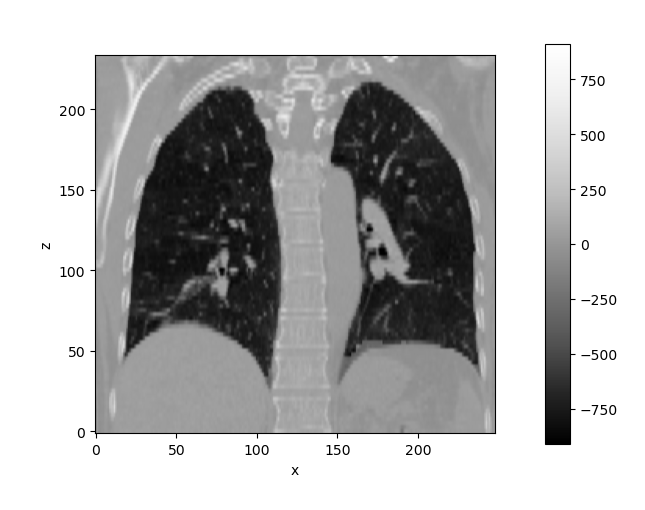

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


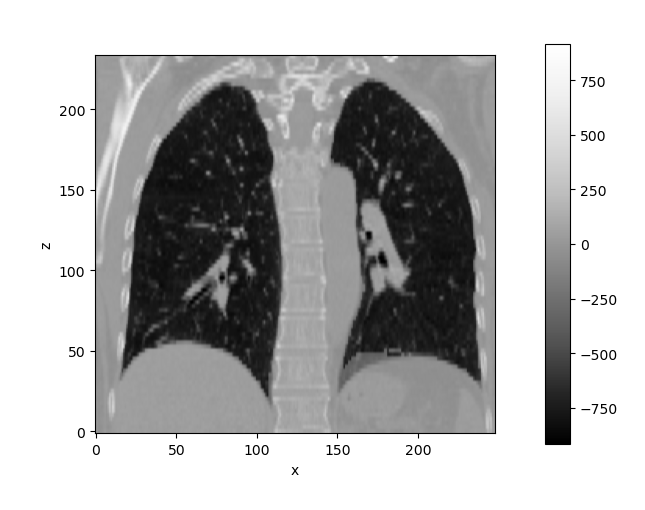

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [6]:
project.visual.view(ee_anat_image * ee_overlay, x='x', y='z', cmap='Greys_r')
project.visual.view(ei_anat_image * ei_overlay, x='x', y='z', cmap='Greys_r')

<IPython.core.display.Javascript object>


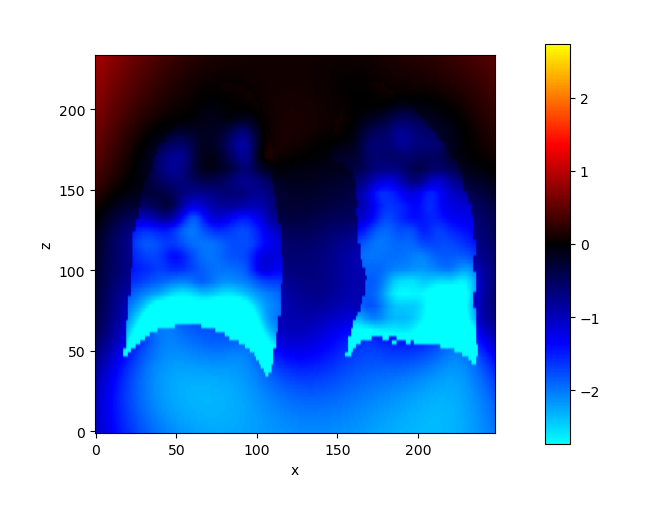

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [7]:
project.visual.view(reg_disp_image * ee_overlay, x='x', y='z')

<IPython.core.display.Javascript object>


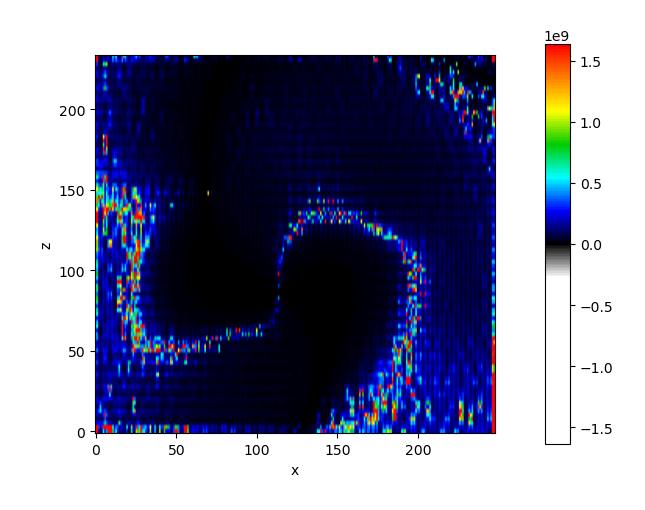

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [8]:
# direct inversion

dx_image = reg_disp_image.differentiate('x')
dy_image = reg_disp_image.differentiate('y')
dz_image = reg_disp_image.differentiate('z')

dxx_image = dx_image.differentiate('x')
dyy_image = dy_image.differentiate('y')
dzz_image = dz_image.differentiate('z')

laplacian_image = dxx_image + dyy_image + dzz_image

rho = 1000
omega = 2 * np.pi * 1
elast_image = -rho * omega**2 * (reg_disp_image.sum('component') / laplacian_image.sum('component'))
elast_image.name = 'elasticity'

project.visual.view(np.abs(elast_image) * ee_overlay, x='x', y='z', cmap=project.visual.mre_color_map())

In [39]:
%%time
ee_lung_mesh = pygalmesh.generate_from_array(
    ee_lung_mask.values.astype(np.uint16),
    voxel_size=case.resolution,
    max_cell_circumradius=20.0,
    odt=True
)

CPU times: user 148 ms, sys: 16.8 ms, total: 165 ms
Wall time: 168 ms


In [40]:
%%time
vertices = ee_lung_mesh.points
facets = ee_lung_mesh.cells[0].data
tetras = ee_lung_mesh.cells[1].data

tetra_facets = np.concatenate([
    tetras[:,[0,1,2]],
    tetras[:,[0,1,3]],
    tetras[:,[0,2,3]],
    tetras[:,[1,2,3]],
    
    tetras[:,[2,1,0]],
    tetras[:,[3,1,0]],
    tetras[:,[3,2,0]],
    tetras[:,[3,2,1]],
])

#angles = project.meshing.compute_angles_to_interior(vertices, facets, tetras)
#tetra_angles = project.meshing.compute_angles_to_interior(vertices, tetra_facets, tetras)

vertices.shape, facets.shape, tetras.shape

CPU times: user 893 µs, sys: 0 ns, total: 893 µs
Wall time: 673 µs


((301, 3), (920, 3), (997, 4))

<IPython.core.display.Javascript object>


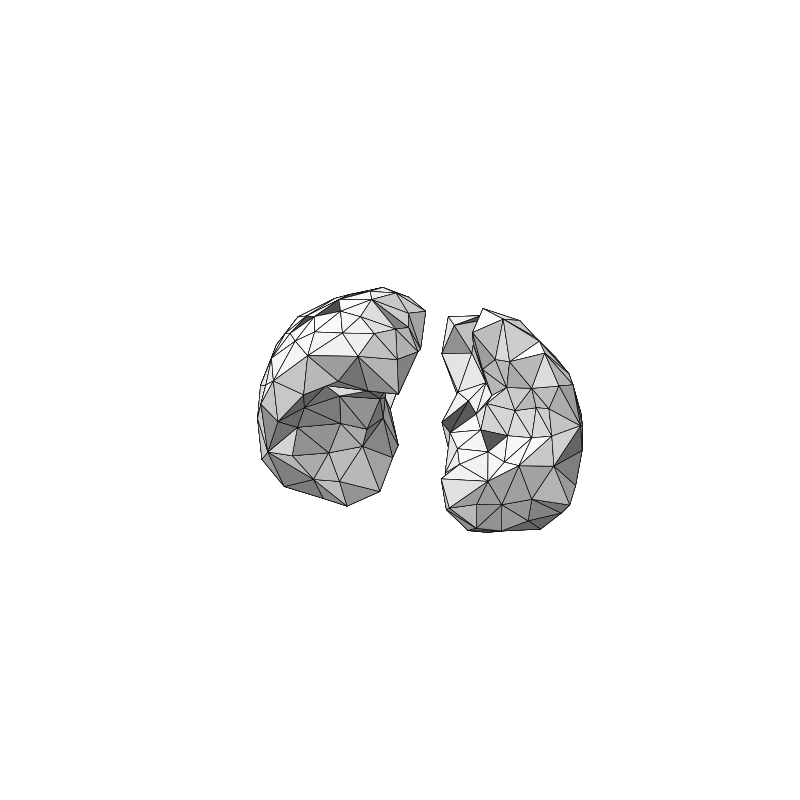

In [41]:
# view surface mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    facets, #[angles > 0],
    facecolors='white',
    edgecolors='black',
    shade=True,
    alpha=1.0,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

<IPython.core.display.Javascript object>


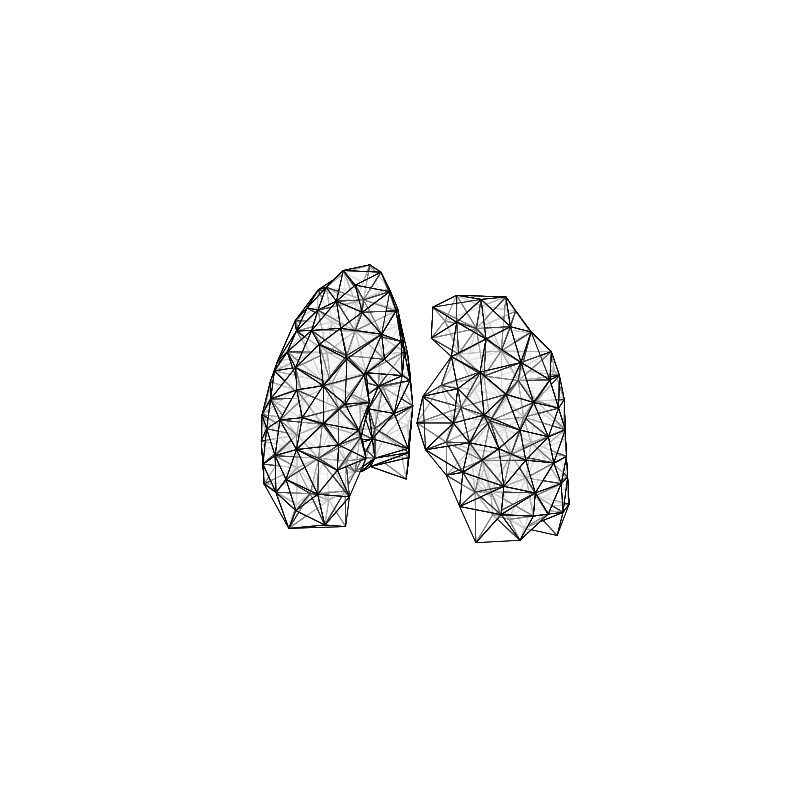

In [42]:
# view volume mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    tetra_facets,
    facecolors='white',
    edgecolors='black',
    alpha=0.1,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

In [43]:
import meshio
from mpi4py import MPI

def convert_to_fe_mesh(points, cells):
    '''
    Convert from meshio to fenics mesh.
    '''
    mesh_file = 'temp.xdmf'
    meshio.write_points_cells(mesh_file, points, [(cells.type, cells.data)])
    fe_mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, mesh_file) as f:
        f.read(fe_mesh)
    return fe_mesh

ee_lung_fe_mesh = convert_to_fe_mesh(ee_lung_mesh.points, ee_lung_mesh.cells[1])

In [44]:
%%time
u_tensor = torch.as_tensor(reg_disp_image.values)
print(u_tensor.shape)

u_func_space = fe.VectorFunctionSpace(ee_lung_fe_mesh, 'P', 1)
u_func_dofs = project.interpolate.image_to_dofs(u_tensor, case.resolution, u_func_space)
print(u_func_dofs.shape)

torch.Size([256, 256, 94, 3])
torch.Size([301, 3])
CPU times: user 3.06 ms, sys: 4.98 ms, total: 8.04 ms
Wall time: 110 ms


In [45]:
%%time
u_interp = project.interpolate.dofs_to_image(u_func_dofs, u_func_space, case.shape, case.resolution)
print(u_interp.shape)

(256, 256, 94) (256, 256, 94, 3)
(256, 256, 94, 3)
CPU times: user 1min 8s, sys: 133 ms, total: 1min 8s
Wall time: 1min 8s


<IPython.core.display.Javascript object>


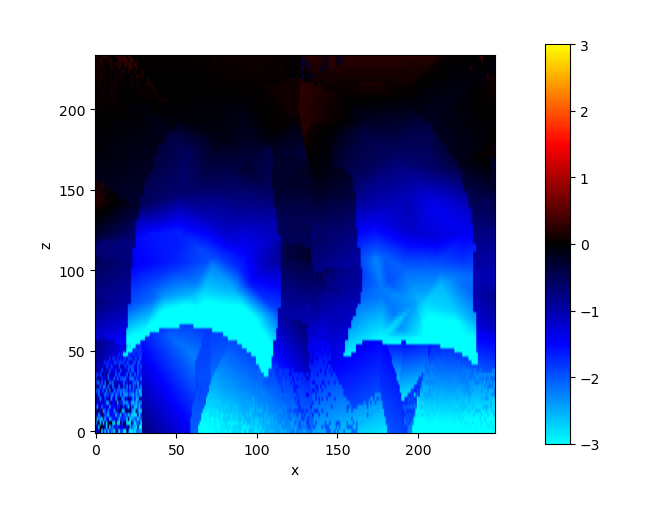

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


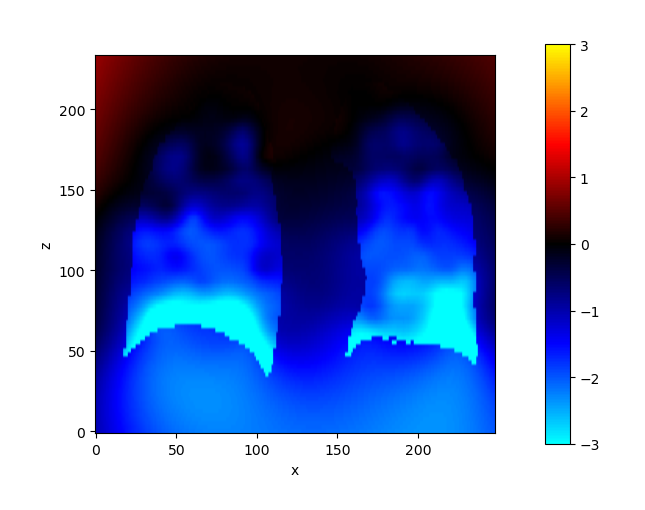

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [47]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_interp) * ee_overlay, x='x', y='z', vmin=-3, vmax=3)
project.visual.XArrayViewer(reg_disp_image * ee_overlay, x='x', y='z', vmin=-3, vmax=3)

## Physical model

Conservation of momentum
$$
    \nabla\cdot\sigma + \mathbf{b} = 0
$$

Isotropic linear elasticity
$$
    \sigma = 2 \mu \epsilon + \lambda \operatorname{tr}(\epsilon) \mathbf{I}
$$

Strain-displacement relation
$$
    \epsilon = \tfrac{1}{2} \left( \nabla \mathbf{u} + \nabla \mathbf{u}^\top \right)
$$

Weak formulation
$$
\begin{align*}
    \nabla\cdot\sigma + \mathbf{b} &= 0 \\
    -\nabla\cdot\sigma &= \mathbf{b} \\
    -\int_\Omega (\nabla\cdot\sigma)\cdot\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} \\
    \int_\Omega \sigma\cdot\nabla\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} (\sigma\cdot\mathbf{n})\cdot\mathbf{v} \,d\mathbf{s} \\
    \int_\Omega \sigma(\mathbf{u})\cdot\epsilon(\mathbf{v}) \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} \mathbf{t}\cdot\mathbf{v} \,d\mathbf{s}
\end{align*}
$$



In [137]:
%%time
class PDESolver(torch_fenics.FEniCSModule):

    def __init__(self, mesh):
        super().__init__()
        
        # initialize function spaces
        self.u_func_space = fe.VectorFunctionSpace(mesh, 'P', 1)
        self.mu_func_space = fe.FunctionSpace(mesh, 'P', 1)
            
    def input_templates(self):
        return (
            fa.Function(self.u_func_space),
            fa.Function(self.mu_func_space)
        )

    def solve(self, u_true, mu):

        # define physical parameters
        g   = 9.8 # gravitational acceleration (m/s^2)
        rho = 1.0 # mass density (kg/m^3)

        E  = 3e3 # Young's modulus (Pa = N/m^2)
        nu = 0.4 # Poisson's ratio (unitless)

        lam = E*nu/((1 + nu)*(1 - 2*nu)) # Lame's first parameter (Pa)
        #mu  = E   /(2*(1 + nu))          # shear modulus (Pa) 

        # set displacement boundary condition
        u_bc = fa.DirichletBC(self.u_func_space, u_true, 'on_boundary')

        # body force and traction
        b = fa.Constant((0, 0, -rho * g))
        t = fa.Constant((0, 0, 0))

        # define stress and strain
        def epsilon(u):
            return (fe.grad(u) + fe.grad(u).T) / 2

        def sigma(u):
            I = fe.Identity(u.geometric_dimension())
            return lam * fe.div(u) * I + 2 * mu * epsilon(u)

        # setup variational problem
        u = fe.TrialFunction(self.u_func_space)
        v = fe.TestFunction(self.u_func_space)

        a = fe.inner(sigma(u), epsilon(v)) * fe.dx
        L = fe.dot(b, v) * fe.dx + fe.dot(t, v) * fe.ds

        # solve for displacement
        u_pred = fa.Function(self.u_func_space)
        fa.solve(a == L, u_pred, u_bc)

        return u_pred

pde_solver = PDESolver(ee_lung_fe_mesh)

u_tensor = torch.as_tensor(reg_disp_image.values)
mu_tensor = torch.randn(case.shape, dtype=torch.float64) + 3e3

u_func_dofs = project.interpolate.image_to_dofs(u_tensor, case.resolution, pde_solver.u_func_space)
u_func_dofs.requires_grad = False

mu_func_dofs = project.interpolate.image_to_dofs(mu_tensor, case.resolution, pde_solver.mu_func_space)
mu_func_dofs.requires_grad = True

u_pred_func_dofs = pde_solver.forward(u_func_dofs.unsqueeze(0), mu_func_dofs.unsqueeze(0))[0]

CPU times: user 271 ms, sys: 120 ms, total: 390 ms
Wall time: 268 ms


In [138]:
(u_pred_func_dofs.isnan()).sum().item()

0

In [140]:
L = F.mse_loss(u_pred_func_dofs, u_func_dofs)
print(L)
L.backward()
print(u_func_dofs.grad)
print(mu_func_dofs.grad)

tensor(0.0595, dtype=torch.float64, grad_fn=<MseLossBackward0>)
None
tensor([ 0.0000e+00, -4.1592e-08, -1.1300e-07, -3.2578e-09, -3.7030e-08,
        -7.6232e-09,  2.9266e-09,  0.0000e+00, -6.0281e-08, -1.6399e-07,
        -1.6871e-07, -2.3000e-08, -2.5064e-07, -7.0618e-08, -4.8683e-08,
        -3.2511e-08,  2.4065e-08, -6.7531e-08, -3.2078e-08, -3.2899e-08,
        -9.4628e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.5904e-08,
        -2.4288e-09,  4.6998e-08, -3.9567e-08, -2.1902e-07, -1.0661e-07,
        -2.4145e-07, -1.7718e-07, -1.0294e-07,  1.1116e-08, -6.0533e-08,
        -3.9716e-08, -7.8002e-08, -5.7114e-08, -6.2386e-08, -1.5710e-07,
        -2.6559e-07, -1.2553e-07, -6.3766e-08, -1.4711e-07, -3.0114e-07,
        -2.2527e-07, -1.5797e-07, -4.4330e-08, -9.2310e-08, -1.4327e-08,
        -3.6361e-08, -1.8752e-09,  0.0000e+00, -5.8129e-08,  1.7165e-08,
        -6.1707e-08, -2.4586e-07, -1.7492e-07, -1.4109e-07, -9.3547e-08,
        -2.5687e-08, -3.2955e-08, -7.4308e-08, -6.4949e

In [147]:
import torch.nn.functional as F
from torch import optim

mu_func_dofs.requires_grad = True

optimizer = optim.Adam([mu_func_dofs], lr=5e-1)

for i in range(1000):
    optimizer.zero_grad()

    u_pred_func_dofs = pde_solver.forward(u_func_dofs.unsqueeze(0), mu_func_dofs.unsqueeze(0))[0]

    loss = F.mse_loss(u_pred_func_dofs, u_func_dofs)
    print((i+1), loss.item())

    loss.backward()
    optimizer.step()


1 0.05691703435014287
2 0.05691178940281761
3 0.056906546228537004
4 0.05690130485442351
5 0.05689606530739671
6 0.056890827614112814
7 0.05688559180090548
8 0.05688035789372966
9 0.056875125918107484
10 0.056869895899077476
11 0.05686466786114709
12 0.05685944182824887
13 0.056854217823700384
14 0.05684899587016852
15 0.05684377598963748
16 0.05683855820338134
17 0.056833342531940605
18 0.05682812899510335
19 0.056822917611890136
20 0.05681770840054338
21 0.05681250137852005
22 0.056807296562488924
23 0.056802093968330636
24 0.05679689361114158
25 0.056791695505240464
26 0.05678649966417806
27 0.05678130610074938
28 0.05677611482700806
29 0.05677092585428293
30 0.05676573919319657
31 0.056760554853684725
32 0.0567553728450178
33 0.056750193175822854
34 0.056745015854106656
35 0.0567398408872793
36 0.05673466828217833
37 0.0567294980450928
38 0.056724330181787776
39 0.05671916469752867
40 0.05671400159710518
41 0.05670884088485512
42 0.05670368256468761
43 0.05669852664010617
44 0.0566

346 0.055240164161849334
347 0.055235666148291944
348 0.05523117003631408
349 0.05522667582437618
350 0.05522218351094044
351 0.055217693094470555
352 0.05521320457343215
353 0.055208717946292535
354 0.055204233211520785
355 0.055199750367587674
356 0.05519526941296564
357 0.05519079034612888
358 0.05518631316555338
359 0.055181837869716754
360 0.055177364457098345
361 0.05517289292617922
362 0.05516842327544221
363 0.05516395550337177
364 0.055159489608454085
365 0.055155025589177
366 0.055150563444030194
367 0.05514610317150491
368 0.05514164477009412
369 0.05513718823829247
370 0.0551327335745964
371 0.05512828077750392
372 0.055123829845514706
373 0.05511938077713025
374 0.055114933570853626
375 0.05511048822518955
376 0.05510604473864446
377 0.05510160310972659
378 0.055097163336945615
379 0.05509272541881303
380 0.055088289353841906
381 0.05508385514054707
382 0.055079422777444965
383 0.05507499226305361
384 0.055070563595892845
385 0.05506613677448403
386 0.05506171179735025
387

685 0.05381522872560611
686 0.05381129710555282
687 0.05380736695057522
688 0.053803438259602515
689 0.053799511031565134
690 0.05379558526539448
691 0.053791660960023
692 0.0537877381143844
693 0.05378381672741333
694 0.053779896798045505
695 0.05377597832521784
696 0.05377206130786825
697 0.05376814574493573
698 0.0537642316353604
699 0.053760318978083366
700 0.05375640777204692
701 0.053752498016194264
702 0.05374858970946985
703 0.05374468285081911
704 0.05374077743918858
705 0.0537368734735258
706 0.053732970952779485
707 0.053729069875899226
708 0.053725170241835866
709 0.05372127204954125
710 0.05371737529796827
711 0.05371347998607086
712 0.05370958611280404
713 0.053705693677123856
714 0.05370180267798747
715 0.05369791311435302
716 0.05369402498517973
717 0.05369013828942792
718 0.05368625302605887
719 0.05368236919403496
720 0.05367848679231959
721 0.05367460581987734
722 0.05367072627567356
723 0.05366684815867492
724 0.05366297146784892
725 0.05365909620216429
726 0.053655

In [149]:
%%time
u_pred_image = project.interpolate.dofs_to_image(u_pred_func_dofs, pde_solver.u_func_space, case.shape, case.resolution)

(256, 256, 94) (256, 256, 94, 3)
CPU times: user 1min 7s, sys: 159 ms, total: 1min 7s
Wall time: 1min 7s


In [152]:
%%time
mu_pred_image = project.interpolate.dofs_to_image(mu_func_dofs, pde_solver.mu_func_space, case.shape, case.resolution)

(256, 256, 94) (256, 256, 94, 3)
CPU times: user 1min, sys: 103 ms, total: 1min 1s
Wall time: 1min 1s


<IPython.core.display.Javascript object>


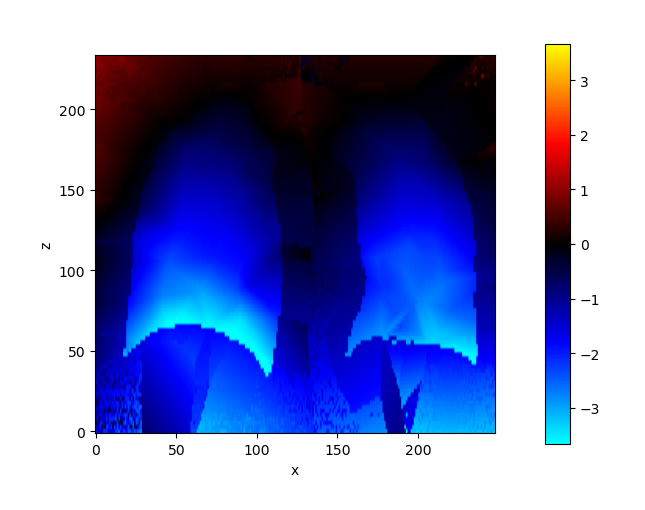

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


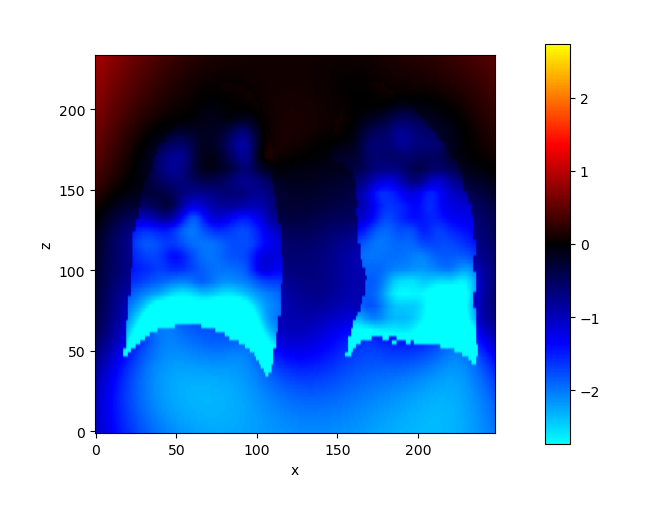

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


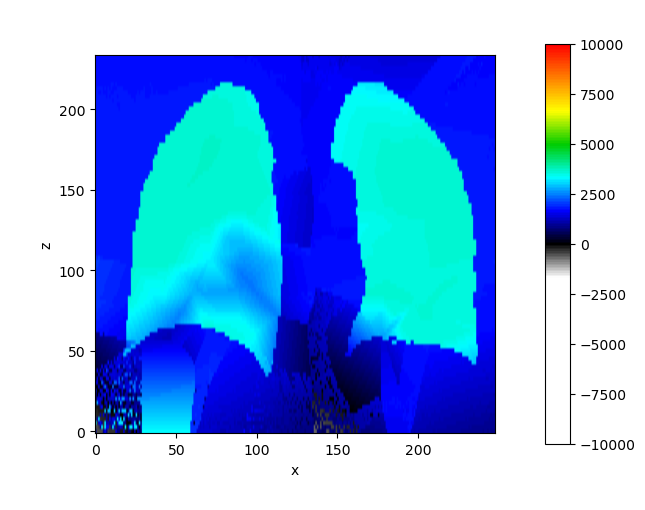

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [154]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_pred_image) * ee_overlay, x='x', y='z')
project.visual.XArrayViewer(reg_disp_image * ee_overlay, x='x', y='z')
project.visual.view(mu_pred_image * ee_overlay, x='x', y='z', cmap=project.visual.mre_color_map(), vmin=-1e4, vmax=1e4)

In [ ]:
def estimate_limit(x, expand=0.1):
    x_min, x_max = np.min(x), np.max(x)
    x_range = (x_max - x_min)
    x_min -= expand * x_range / 2
    x_max += expand * x_range / 2
    return x_min, x_max

def plot_func(f):

    mesh = f.function_space().mesh()

    vertices = mesh.coordinates()
    n_vertices = mesh.num_vertices()
    values = f.compute_vertex_values(mesh)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d', aspect='equal')

    X = [vertices[:,i] for i in range(3)]
    U = [values[i * n_vertices:(i + 1) * n_vertices] for i in range(3)]
    
    print(np.mean(np.linalg.norm(U, axis=1), axis=0))
       
    args = X + U
    ax.quiver(*args)
    
    ax.set_xlim(estimate_limit(vertices.flatten()))
    ax.set_ylim(estimate_limit(vertices.flatten()))
    ax.set_zlim(estimate_limit(vertices.flatten()))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

plot_func(disp_fe_func)

In [ ]:
project.visual.view((reg_disp_image * 0 + sim_disp_image) * ee_lung_mask, x='x', y='z')